# Quickstart Notebook for Databricks

This notebook is intended to give an overview of the key functionality within the XNN Platform and get you up to speed with the Hybrid Intelligence framework.

# Check Environment Variables
Before installing Hybrid Intelligence in the notebook you need to set these Environment Variables externally as described in the User Guide https://docs.umnai.com/set-up-your-environment. 
This section checks that the environment variables have been set correctly and throws an error if not.

In [1]:
import os

umnai_env_vars = {
    'UMNAI_CLIENT_ID',
    'UMNAI_CLIENT_SECRET',
    'PIP_EXTRA_INDEX_URL',
}

umnai_env_vars.update({
    'DATABRICKS_HOST',
    'DATABRICKS_TOKEN',
})

if not umnai_env_vars.issubset(os.environ.keys()):
    raise ValueError(
        'UMNAI environment variables not set correctly. They need to be set before using the Umnai library.'
    )

# Install Hybrid Intelligence
Next we install the UMNAI Platform.

In [2]:
%pip install umnai-platform --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
dbutils.library.restartPython()

# Set Workspace Paths
Now we will set the workspace path and the experiment path.

## Install Databricks SDK

In [4]:
%pip install databricks-sdk --quiet

Note: you may need to restart the kernel to use updated packages.


## Select Shared Workspace
On Databricks you can select whether you would like the workspace to be created in the shared area (available to all users in your account) or in your personal user account area.

In [5]:
# Set to 1 if you want to use shared or 0 to use personal user account area.
USE_SHARED_WORKSPACE = 1 

## Set Paths
Next the workspace and experiment paths are set automatically.

In [6]:
from databricks.sdk import WorkspaceClient

EXP_NAME = 'quickstart_adult_income'
w = WorkspaceClient()

WS_PATH = '/dbfs/FileStore/workspaces/'+EXP_NAME

if USE_SHARED_WORKSPACE:
    EXP_PREFIX = '/Shared/experiments/'
else:
    USERNAME = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
    EXP_PREFIX = f'/Users/{USERNAME}/experiments/'
w.workspace.mkdirs(EXP_PREFIX)

EXP_PATH = EXP_PREFIX + EXP_NAME

# Import and Prepare Dataset
Import the dataset to a Pandas DataFrame and the clean data in preparation for onboarding into Hybrid Intelligence.

In [7]:
import pandas as pd
import numpy as np

# Import Adult Income Dataset to pandas dataframe: 
# This dataset can be downloaded from https://archive.ics.uci.edu/dataset/2/adult 
column_names = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus", "Occupation", "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]
dataset_df = pd.read_csv('https://raw.githubusercontent.com/umnaibase/umnai-examples/main/data/adult.data', names = column_names)


# Data Preparation:
dataset_df = dataset_df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)    # Remove whitespaces
dataset_df["Income"] = np.where((dataset_df["Income"] == '<=50K'), 0, 1)                # Replace Target values with [0,1]
dataset_df.tail(5)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,1


# Create or Open a Hybrid Intelligence Workspace
Workspaces are used by the Hybrid Intelligence framework to organize your data and models together in one place.

In [8]:
from umnai.workspaces.context import Workspace

# Open a workspace
ws = Workspace.open(
    path = WS_PATH,
    experiment= EXP_PATH
)

ws # Prints workspace details to confirm created/opened

# Onboard Hybrid Intelligence Dataset

Onboard the Pandas DataFrame into a Hybrid Intelligence dataset.

In [9]:
from umnai.data.datasets import Dataset
from umnai.data.enums import PredictionType

dataset = Dataset.from_pandas(
    dataset_df,
    prediction_type=PredictionType.CLASSIFICATION,
    features=list(dataset_df.drop(['Income'], axis=1).columns),    # All columns except 'Income' are features
    targets=['Income'],
)

dataset # Prints dataset details to confirm created/opened

2024/03/01 13:31:39 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



MLFLOW Run ID: fbf74cc75e97452dace3f8400b335539:   0%|          | 0/36 [00:00<?, ?it/s]

Processing Tasks:   0%|          | 0/15 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Processing Tasks:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: /dbfs/FileStore/workspaces/quickstart_adult_income/preprocessing/dataset_name=Dataset_09cbcd7b/assets


Dataset(id=c2b687c4-2aff-4185-b3e8-7986a00c4d83; name=Dataset_09cbcd7b; is_named=False; workspace_id=None)

# View Data Schema
View the automatically generated data schema.

In [10]:
pd.DataFrame(dataset.data_schema.dict()['fields'])

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income,observation_type
name,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income,observation_type
dtype,INT64,STRING,INT64,STRING,INT64,STRING,STRING,STRING,STRING,STRING,INT64,INT64,INT64,STRING,INT64,STRING
shape,[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]
is_categorical,False,True,False,True,False,True,True,True,True,True,False,False,False,True,False,True
is_datetime,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
is_primary,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
is_ignored,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
is_geospatial,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
is_anchor,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
is_protected,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Dataset Statistics
Display useful statistics about the dataset.

In [11]:
pd.DataFrame(dataset.stats)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
null_count,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.00000
minimum,1.700000e+01,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,1.000000e+00,NaN,0.00000
maximum,9.000000e+01,NaN,1.484705e+06,NaN,16.000000,NaN,NaN,NaN,NaN,NaN,9.999900e+04,4.356000e+03,9.900000e+01,NaN,1.00000
sum,1.256257e+06,NaN,6.179373e+09,NaN,328237.000000,NaN,NaN,NaN,NaN,NaN,3.508932e+07,2.842700e+06,1.316684e+06,NaN,7841.00000
unique_count,NaN,9.0,NaN,16.0,NaN,7.0,15.0,6.0,5.0,2.0,NaN,NaN,NaN,42.0,2.00000
mean,3.858165e+01,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1.077649e+03,8.730383e+01,4.043746e+01,NaN,0.24081
stddev,1.860557e+02,NaN,1.114046e+10,NaN,6.618687,NaN,NaN,NaN,NaN,NaN,5.454086e+07,1.623720e+05,1.524543e+02,NaN,0.18282


## 1D-Histogram for a Categorical Feature
Display frequency count information for a categorical feature.

In [12]:
dataset.metadata.histogram_1d["Gender"].to_pandas()

,dataset_id,field,field_type,is_categorical,token,bin_index,is_infrequent,is_masked_token,frequency,frequency_fraction,target_min,target_max,target_sum,target_mean,target_var
0,c2b687c42aff4185b3e87986a00c4d83,Gender,FEATURE,True,Female,0,False,False,10771,0.330795,[0],[1],[1179],[0.10946058861758426],[0.09747896815707624]
1,c2b687c42aff4185b3e87986a00c4d83,Gender,FEATURE,True,Male,0,False,False,21790,0.669205,[0],[1],[6662],[0.3057365764111978],[0.21226172225555762]


# Induce a Hybrid Intelligence Model
Induction is the process of creating and training a Hybrid Intelligence model from a dataset.

To induce a model from a dataset, you must first create a ModelInducer that sets up the induction parameters and settings. Then you simply use the ModelInducer to induce an Explanation Structure Model (ESM) from the onboarded dataset.

In [13]:
from umnai.induction.inducer import ModelInducer
from umnai.esm.model import ESM

# Induce a simple model quickly using fast execution parameters
model_inducer = ModelInducer(
    max_interactions=3,
    max_interaction_degree=2,
    max_polynomial_degree=2,
    trials=2,
    estimators=2,
    batch_size=512,
    iterations=2,
)

# # Induce a more realistic model using default Induction parameters
# model_inducer = ModelInducer()

# Create an ESM using Induction
esm = model_inducer.induce(dataset)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/03/01 13:31:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


2024/03/01 13:32:18 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



2024/03/01 13:32:18 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 1ms/step


[Modules] - MLFLOW Run ID: 21d686edd744469b9e72b2b3c9601907:   0%|          | 0/25 [00:00<?, ?it/s]

21/21 [==============================] - 0s 971us/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 3ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 949us/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 3ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 964us/step


21/21 [==============================] - 0s 927us/step


/root/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


/root/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


26/26 [==============================] - 1s 3ms/step


26/26 [==============================] - 1s 3ms/step


2024-03-01 13:33:22.679286: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 13:33:22.680127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 13:33:22.680405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 13:33:22.735765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 13:33:22.735812: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register f

/databricks/python3/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(
/databricks/python3/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


2024/03/01 13:33:29 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



/root/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2024/03/01 13:33:30 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - qu

/root/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


26/26 [==============================] - 1s 4ms/step


26/26 [==============================] - 1s 3ms/step


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convertWARNING:tensorflow:AutoGraph could not transform <bound method PolynomialTransformer.call of <umnai.models.xnn.layers.transformation.PolynomialTransformer object at 0x7f1d2907ca00>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convertWARNING:tensorflow:AutoGraph could not transform <bound method LinearEstimator.call of <umnai.models.xnn.layers.linear.LinearEstimator object at 0x7f1d28368ca0>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/root/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024/03/01 13:35:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: /tmp/tmpbnpf254z/model/data/model/assets


# Save the Model
When you induce a model successfully it is automatically saved in the MLflow run. You can load the model from the MLflow run with the MLflow run ID.

You can also save a model to your workspace. You should note down the ESM ID as you will need it to load the model from the workspace.

In [14]:
# Note ESM ID and MLFLow Run ID
print("MLflow Run ID: ", esm.producer_run_id)
print("ESM ID: ", esm.id)

MLflow Run ID:  21d686edd744469b9e72b2b3c9601907
ESM ID:  Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601907


In [15]:
# Save the ESM to your workspace
esm.save_to_workspace()

INFO:tensorflow:Assets written to: /dbfs/FileStore/workspaces/quickstart_adult_income/models/Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601907/assets


# Inference: Query a Model 
When you query a Hybrid Intelligence model you get predictions together with explanations in real-time.

## Create a Query
You can create a Query object from a dictionary.

In [16]:
from umnai.explanations.local import Query
import pandas as pd

query = Query({
    'Age': [39],
    'WorkClass': ['State-gov'],
    'fnlwgt': [77516],
    'Education': ['Bachelors'],
    'EducationNum': [13],
    'MaritalStatus': ['Never-married'],
    'Occupation': ['Adm-clerical'],
    'Relationship': ['Not-in-family'],
    'Race': ['White'],
    'Gender': ['Male'],
    'CapitalGain': [2174],
    'CapitalLoss': [0],
    'HoursPerWeek': [40],
    'NativeCountry': ['United-States']
})

## Instantiate a Local Explainer
Create a LocalExplainer to define the ESM you want to query. The local explainer lets you extract query explanations and predictions in real-time.

In [17]:
from umnai.explanations.local import LocalExplainer

# Instantiate a LocalExplainer:
local_explainer = LocalExplainer(esm)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Submit the Query
Then you should pass the Query object to the local explainer instance. This will return a QueryResult that includes the prediction and the query explanation.

In [18]:
# Query the model:
query_result = local_explainer(query)

#  Display the Query Result together with the explanation
query_result.data

{'query_input': {'Age': array([39]),
  'WorkClass': array(['State-gov'], dtype=object),
  'fnlwgt': array([77516]),
  'Education': array(['Bachelors'], dtype=object),
  'EducationNum': array([13]),
  'MaritalStatus': array(['Never-married'], dtype=object),
  'Occupation': array(['Adm-clerical'], dtype=object),
  'Relationship': array(['Not-in-family'], dtype=object),
  'Race': array(['White'], dtype=object),
  'Gender': array(['Male'], dtype=object),
  'CapitalGain': array([2174]),
  'CapitalLoss': array([0]),
  'HoursPerWeek': array([40]),
  'NativeCountry': array(['United-States'], dtype=object)},
 'scenario_id': None,
 'context_id': None,
 'query_row_hash': array([153092249520382873164400753216439156323], dtype=object),
 'query_created_time': datetime.datetime(2024, 3, 1, 13, 35, 41, tzinfo=<UTC>),
 'model_id': 'Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601907',
 'model_intercept': -0.82649505,
 'dataset_id': 'c2b687c42aff4185b3e87986a00c4d83',
 'run_id': None,
 'run_created_time':

# Explore and Explain a Model with Model Views

You can explore and explain a model with these pre-formatted Model Views:
- Model Summary View
- Partial Dependency View

## ModelSummaryView
The Model Summary View gives you an overview of the key parameters, inputs and outputs of the model, and of each module within it.

In [19]:
from umnai.views.model_summary import ModelSummaryView

model_summary_view = ModelSummaryView(esm=esm)
model_summary_view.data

{'model_id': 'Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601907',
 'model_name': 'esm',
 'model_title': None,
 'model_created': datetime.datetime(2024, 3, 1, 13, 35, 10, tzinfo=<UTC>),
 'model_last_trained': datetime.datetime(2024, 3, 1, 13, 35, 10, tzinfo=<UTC>),
 'model_uvc': '698d58d058f8a5b22891ebe76866e5476703e1d7f48de3cd2a7722a6f1748db2',
 'model_intercept': -0.8264950513839722,
 'has_personal_individual_data': False,
 'has_reuse_restrictions': False,
 'model_doi': '',
 'model_copyright': '',
 'n_input_features': 14,
 'n_transformed_features': 108,
 'n_output_targets': 1,
 'features': ['Age',
  'WorkClass',
  'fnlwgt',
  'Education',
  'EducationNum',
  'MaritalStatus',
  'Occupation',
  'Relationship',
  'Race',
  'Gender',
  'CapitalGain',
  'CapitalLoss',
  'HoursPerWeek',
  'NativeCountry'],
 'targets': ['Income'],
 'n_modules': 16,
 'n_partitions': 28,
 'max_interaction_degree': 2,
 'model_interaction_count': 34,
 'max_width': 2,
 'max_depth': 4,
 'n_categorical_features': 8

## PartialDependencyView
The Partial Dependency View shows you the transfer function of a specific module, showing you how a module's attribution varies to its inputs.

In [20]:
from umnai.views.partial_dependency import PartialDependencyView

# Select a module
selected_module = 'Age'

# Generate the view
partial_dependency_view = PartialDependencyView(esm=esm, module=selected_module, use_training_data=False)

# Display the results
partial_dependency_view.data

,input_feature.Age,attribution.Income,attribution_normalized.Income,module_partition_index,rule_id,condition_expr_friendly,attribution_delta.Income
0,17,-0.631876,-0.041111,0,e09afdd2a07543c1a8fbcb6be019489f,Age ≤ 29.5,NaN
1,18,-0.631832,-0.041108,0,e09afdd2a07543c1a8fbcb6be019489f,Age ≤ 29.5,0.000043
2,19,-0.631789,-0.041105,0,e09afdd2a07543c1a8fbcb6be019489f,Age ≤ 29.5,0.000043
3,20,-0.631745,-0.041103,0,e09afdd2a07543c1a8fbcb6be019489f,Age ≤ 29.5,0.000044
4,21,-0.631701,-0.041100,0,e09afdd2a07543c1a8fbcb6be019489f,Age ≤ 29.5,0.000044
...,...,...,...,...,...,...,...
68,86,0.094522,0.006150,3,1bf54d4abf9d428f9f1bd386db7503d1,Age > 50.5,-0.002012
69,87,0.093505,0.006084,3,1bf54d4abf9d428f9f1bd386db7503d1,Age > 50.5,-0.001018
70,88,0.092480,0.006017,3,1bf54d4abf9d428f9f1bd386db7503d1,Age > 50.5,-0.001025
71,89,0.091446,0.005950,3,1bf54d4abf9d428f9f1bd386db7503d1,Age > 50.5,-0.001033


### Sample plot
You can use matplotlib or any other vizualisation tool to plot the Attribution as a function of the input value. 
Here we show a sample plot for the module 'Age'

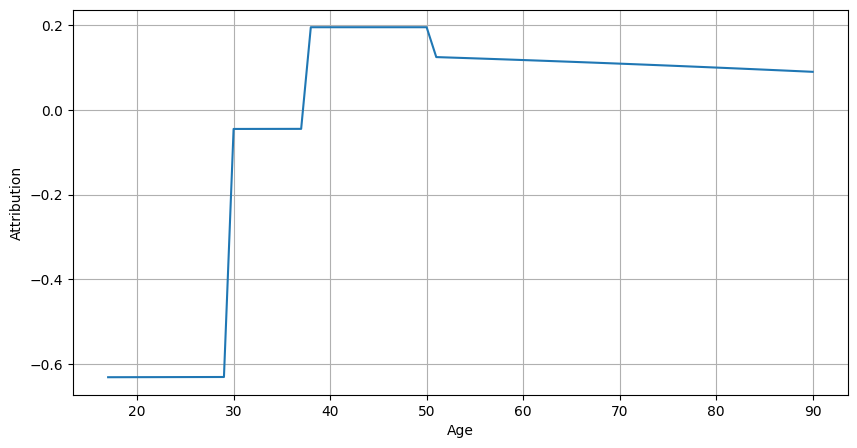

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.xlabel(selected_module)
plt.ylabel("Attribution")
plt.grid(which='major', axis='both')
plt.plot(partial_dependency_view.data['input_feature.Age'], partial_dependency_view.data['attribution.Income'])
plt.show()

# Explain a Query

To explain and explore a QueryResult, you can use the following pre-formatted views.
- Feature Attribution View: shows the attributions of a query in terms of input features only.
- Interaction Attribution View: shows the module attributions of a query, interaction decompositions, and the bins of the activated partitions.

## FeatureAttributionView

With the FeatureAttributionView, you can view the attributions of a query in terms of input features only. This means that decomposed attributions (from interactions) are rolled up into their respective features.

You can create the view by passing the query result, and you can then retrieve the formatted dataframe using the data attribute.

In [22]:
from umnai.views.feature_attribution import FeatureAttributionView

# Create the view and display the data
feature_attribution_view = FeatureAttributionView(query_result)
feature_attribution_view.data

/usr/lib/python3.10/functools.py:981: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  val = self.func(instance)


,input_feature,feature_attribution,feature_attribution_absolute,feature_attribution_normalized,grouped_features,feature_input
0,MaritalStatus,-0.406038,0.406038,0.274652,None,Never-married
1,Relationship,-0.347811,0.347811,0.235266,None,Not-in-family
2,Age,0.195883,0.195883,0.132499,None,39
3,Occupation,-0.153580,0.153580,0.103885,None,Adm-clerical
4,CapitalGain,0.101701,0.101701,0.068793,None,2174
5,Education,0.058850,0.058850,0.039807,None,Bachelors
6,fnlwgt,-0.057741,0.057741,0.039057,None,77516
7,Gender,0.046467,0.046467,0.031431,None,Male
8,EducationNum,-0.035791,0.035791,0.024210,None,13
9,WorkClass,-0.028474,0.028474,0.019260,None,State-gov


## InteractionAttributionView
With the InteractionAttributionView, you can view the module attributions of a query together with interaction decompositions and the bins of the activated partitions. 

You can create the view by passing the query result, and you can then retrieve the formatted dataframe using the data attribute.

In [23]:
from umnai.views.interaction_attribution import InteractionAttributionView

# Create the view and display the data
interaction_attribution_view = InteractionAttributionView(query_result)
interaction_attribution_view.data

/usr/lib/python3.10/functools.py:981: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  val = self.func(instance)


,module_id,module_index,module_name,module_partition_index,global_partition_index,rule_id,output_target_index,total_attribution,total_attribution_normalized,input_feature_0,grouped_features_0,input_feature_1,grouped_features_1,feature_attribution_0,feature_attribution_1,feature_input_0,feature_input_1,condition_expr_friendly,summarized_then_expr
0,Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601...,8,MaritalStatus,0,14,6a2db50314174ca3bc4015bf00ece07b,0,-0.406038,0.210645,MaritalStatus,None,None,None,-0.406038,NaN,Never-married,None,"MaritalStatus ≠ ""Married-civ-spouse""",-0.384457290172577 - 0.0215810537338257*(Mari...
1,Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601...,12,Relationship,0,19,ac586818db7043158706bc6c27e657b2,0,-0.260327,0.135053,Relationship,None,None,None,-0.260327,NaN,Not-in-family,None,"Relationship ≠ ""Husband""",-0.336920499801636 + 0.0765932127833366*(Rela...
2,Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601...,14,Education x Relationship,1,23,b704a75268b34c3fb1faa702d8d9bc90,0,-0.214697,0.111380,Education,None,Relationship,None,-0.112694,-0.102003,Bachelors,Not-in-family,"Relationship = ""Not-in-family""",-0.280588895082474 + 0.0345865786075592*(Educ...
3,Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601...,0,Age,2,2,59323be877ed45bc849ae921a92bff4b,0,0.195883,0.101620,Age,None,None,None,0.195883,NaN,39,None,(Age > 37.5) and (Age ≤ 50.5),0.195878028869629 + 9.91896058621933e-8*Age +...
4,Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601...,6,Education,0,12,3c5dc3fdbbbc4ccab03afd9bc62dd2c7,0,0.171544,0.088994,Education,None,None,None,0.171544,NaN,Bachelors,None,FOR ALL,-0.108646295964718 + 0.280190408229828*(Educa...
5,Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601...,10,Occupation,0,17,7c55c16d0cc740a181d69a955fa0c0d6,0,-0.153580,0.079674,Occupation,None,None,None,-0.153580,NaN,Adm-clerical,None,FOR ALL,-0.170280098915100 + 0.0166997294872999*(Occu...
6,Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601...,15,EducationNum x Relationship,1,26,7a100e8550424745a8b91277f3676b14,0,-0.133192,0.069097,EducationNum,None,Relationship,None,-0.147711,0.014519,13,Not-in-family,"(EducationNum > 9.5) and (Relationship ≠ ""Husb...",-0.162526428699493 + 0.00250248052179813*Educ...
7,Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601...,2,EducationNum,1,8,b11d0af4566347cc9fce775b1b20e8cd,0,0.111919,0.058061,EducationNum,None,None,None,0.111919,NaN,13,None,EducationNum > 9.5,0.0979106724262238 + 0.000510117621161044*Edu...
8,Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601...,3,CapitalGain,0,9,66462d063de54b2190fa536ffdff6b69,0,0.101701,0.052761,CapitalGain,None,None,None,0.101701,NaN,2174,None,FOR ALL,-0.0850367844104767 + 8.57723644003272e-5*Cap...
9,Dataset_09cbcd7b_21d686edd744469b9e72b2b3c9601...,1,fnlwgt,0,4,4bb3957deeca4f85a71bee17fb88ee21,0,-0.057741,0.029955,fnlwgt,None,None,None,-0.057741,NaN,77516,None,fnlwgt ≤ 119480.5,-0.0577485486865044 + 3.35306131627842e-17*fn...
